In [25]:
# 导入需要的库
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
import folium
from scipy.stats import fisher_exact

In [2]:
pip install folium geopandas

  Obtaining dependency information for folium from https://files.pythonhosted.org/packages/a2/1a/37c7ee1bc806d6c32621fecc72c19f6a9f9b4369e5e8f406a7c16d49f031/folium-0.15.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/cb/7b/2fb6ab376c78d2e60812ad0bf4b24889309d2aeb543f54efcd586c69907f/geopandas-0.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for branca>=0.6.0 from https://files.pythonhosted.org/packages/2f/e7/603b136221de923055716d23e3047da71f92e0d8ba2c4517ce49a54fe768/branca-0.7.0-py3-none-any.whl.metadata
  Obtaining dependency information for fiona>=1.8.19 from https://files.pythonhosted.org/packages/20/16/6fa71a55e4f2aa5632ec1365b2e1c9575886b081a5bc639e61df7051976d/fiona-1.9.5-cp38-cp38-win_amd64.whl.metadata
     ---------------------------------------- 0.0/51.1 kB ? eta -:--:--
     ---------------------- --------------- 30.7/51.1 kB 660.6 kB/s eta 0:00:01
     -----------------------

In [26]:
# 读取CSV文件
df = pd.read_csv('dataset_space_API_past_launches_raw.csv')  

# 显示数据摘要
df.describe(include='all')

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
count,94.000000,94,94,88.000000,94,94,94,94.000000,94,94,94,64,90.000000,94.000000,94,94.000000,94.000000
unique,NaN,94,2,NaN,11,4,8,NaN,2,2,2,5,NaN,NaN,57,NaN,NaN
top,NaN,2006-03-24,Falcon 9,NaN,GTO,CCSFS SLC 40,True ASDS,NaN,True,False,True,5e9e3032383ecb6bb234e7ca,NaN,NaN,B1049,NaN,NaN
freq,NaN,1,90,NaN,27,55,41,NaN,70,57,71,35,NaN,NaN,6,NaN,NaN
mean,54.202128,NaN,NaN,5919.165341,NaN,NaN,NaN,1.755319,NaN,NaN,NaN,NaN,3.500000,3.010638,NaN,-75.553302,28.581782
std,30.589048,NaN,NaN,4909.689575,NaN,NaN,NaN,1.197544,NaN,NaN,NaN,NaN,1.595288,4.067957,NaN,53.391880,4.639981
min,1.000000,NaN,NaN,20.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,-120.610829,9.047721
25%,28.250000,NaN,NaN,2406.250000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,2.000000,0.000000,NaN,-80.603956,28.561857
50%,52.500000,NaN,NaN,4414.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,4.000000,1.000000,NaN,-80.577366,28.561857
75%,81.500000,NaN,NaN,9543.750000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,5.000000,4.000000,NaN,-80.577366,28.608058


In [27]:
# 使用空格来分割'outcome'列
df[['Outcome', 'Landing']] = df['Outcome'].str.split(expand=True)

# 删除 'landing' 列中值为 'None' 的行
df = df[df['Landing'] != 'None']
df = df[df['Outcome'] != 'None']

# 使用 'PayloadMass' 列的中位数填充其缺失值
median_value = df['PayloadMass'].median()
df['PayloadMass'].fillna(median_value, inplace=True)

df['LandingPad'].fillna('no_use', inplace=True)

In [28]:
df.to_csv('cleaned_data.csv', index=True)

In [12]:
df = df.drop(columns=['Longitude'])
df = df.drop(columns=['Latitude'])
df = df.drop(columns=['Serial'])
df['Block'] = df['Block'].astype('category')

In [7]:
print(df.head())
df.describe(include='all')

    FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
7             11  2013-09-29       Falcon 9        500.0    PO   VAFB SLC 4E   
10            14  2014-04-18       Falcon 9       2296.0   ISS  CCSFS SLC 40   
11            15  2014-07-14       Falcon 9       1316.0   LEO  CCSFS SLC 40   
14            18  2014-09-21       Falcon 9       2216.0   ISS  CCSFS SLC 40   
15            19  2015-01-10       Falcon 9       2395.0   ISS  CCSFS SLC 40   

   Outcome  Flights  GridFins  Reused   Legs                LandingPad  Block  \
7    False        1     False   False  False                    no_use    1.0   
10    True        1     False   False   True                    no_use    1.0   
11    True        1     False   False   True                    no_use    1.0   
14   False        1     False   False  False                    no_use    1.0   
15   False        1      True   False   True  5e9e3032383ecb761634e7cb    1.0   

    ReusedCount Serial   Longitu

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Landing
count,69.000000,69,69,69.000000,69,69,69,69.000000,69,69,69,69,69.000000,69.000000,69,69.000000,69.000000,69
unique,NaN,69,1,NaN,10,3,2,NaN,2,2,2,6,NaN,NaN,38,NaN,NaN,3
top,NaN,2013-09-29,Falcon 9,NaN,ISS,CCSFS SLC 40,True,NaN,True,False,True,5e9e3032383ecb6bb234e7ca,NaN,NaN,B1049,NaN,NaN,ASDS
freq,NaN,1,69,NaN,17,39,60,NaN,65,38,66,33,NaN,NaN,6,NaN,NaN,47
mean,61.652174,NaN,NaN,6504.720290,NaN,NaN,NaN,1.898551,NaN,NaN,NaN,NaN,3.753623,3.971014,NaN,-87.546644,29.629603,NaN
std,28.315360,NaN,NaN,5218.058623,NaN,NaN,NaN,1.296431,NaN,NaN,NaN,NaN,1.518569,4.348668,NaN,15.282036,2.312199,NaN
min,11.000000,NaN,NaN,350.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,-120.610829,28.561857,NaN
25%,38.000000,NaN,NaN,2482.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,3.000000,1.000000,NaN,-80.603956,28.561857,NaN
50%,65.000000,NaN,NaN,4415.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,5.000000,2.000000,NaN,-80.577366,28.561857,NaN
75%,87.000000,NaN,NaN,9600.000000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,5.000000,7.000000,NaN,-80.577366,28.608058,NaN


In [8]:
df.isnull().sum()

FlightNumber      0
Date              0
BoosterVersion    0
PayloadMass       0
Orbit             0
LaunchSite        0
Outcome           0
Flights           0
GridFins          0
Reused            0
Legs              0
LandingPad        0
Block             0
ReusedCount       0
Serial            0
Longitude         0
Latitude          0
Landing           0
dtype: int64

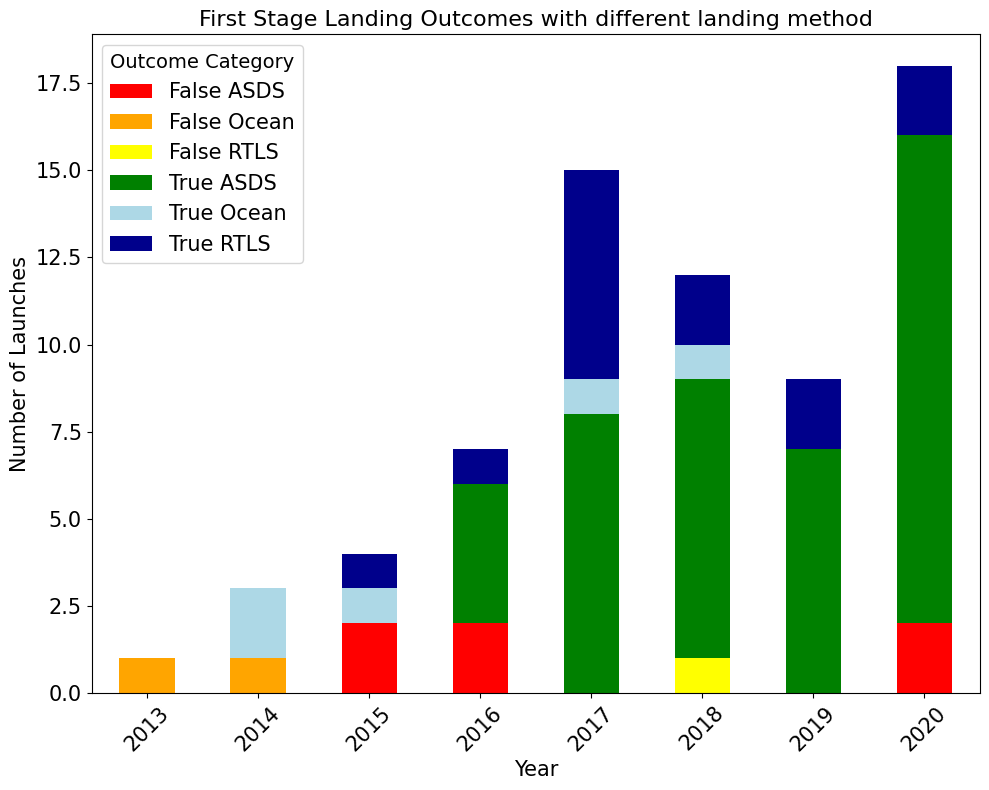

In [13]:
# 创建新列以表示年份
df['Year'] = pd.to_datetime(df['Date']).dt.year

# 创建Outcome分类
df['Outcome_Category'] = df['Outcome'] + ' ' + df['Landing']

# 定义颜色
colors = {
    'True ASDS': 'green',
    'True RTLS': 'darkblue',
    'True Ocean': 'lightblue',
    'False ASDS': 'red',
    'False RTLS': 'yellow',
    'False Ocean': 'orange'
}

# 计算每年每种情况的数量
outcome_counts = df.groupby(['Year', 'Outcome_Category']).size().unstack().fillna(0)

# 画堆叠条形图
ax = outcome_counts.plot(kind='bar', stacked=True, color=[colors[col] for col in outcome_counts.columns], figsize=(10, 8), width=0.5)

plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of Launches', fontsize=15)
plt.title('First Stage Landing Outcomes with different landing method', fontsize=16)
plt.legend(title='Outcome Category', fontsize=15, title_fontsize=14)
plt.xticks(fontsize=15, rotation=45)  # X轴的字体大小和倾斜度
plt.yticks(fontsize=15)  # Y轴的字体大小
plt.tight_layout()
plt.show()


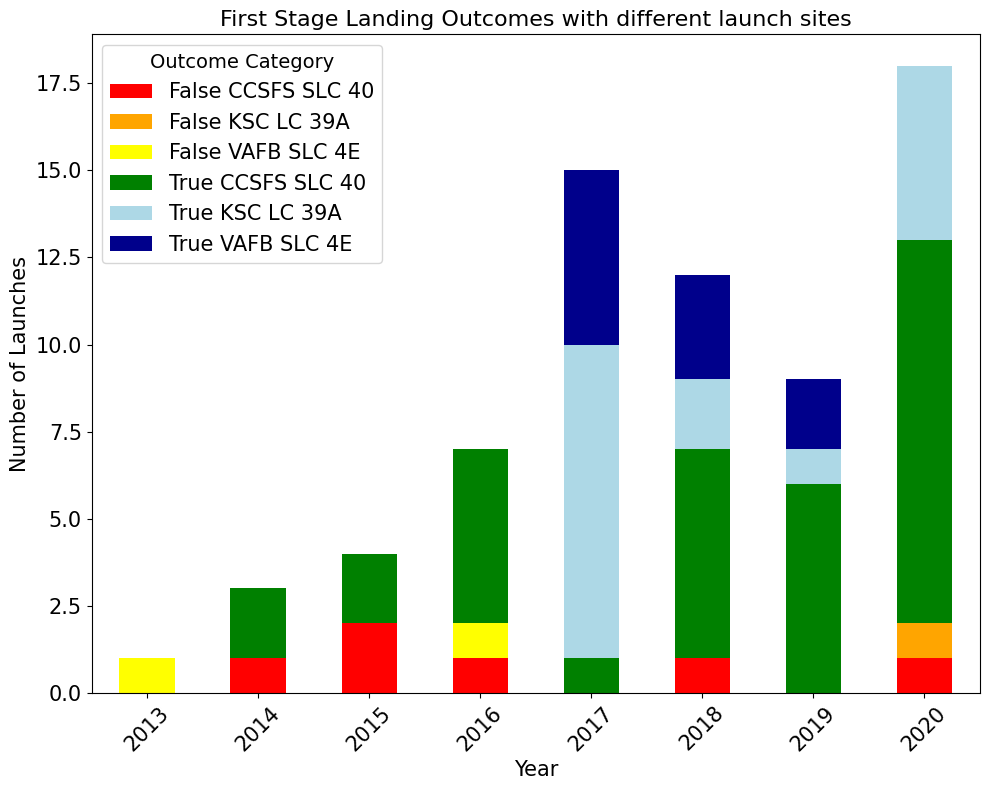

In [14]:
# 创建Outcome分类
df['Outcome_Category_2'] = df['Outcome'] + ' ' + df['LaunchSite']

# 定义颜色
colors = {
    'True CCSFS SLC 40': 'green',
    'True VAFB SLC 4E': 'darkblue',
    'True KSC LC 39A': 'lightblue',
    'False CCSFS SLC 40': 'red',
    'False VAFB SLC 4E': 'yellow',
    'False KSC LC 39A': 'orange'
}

# 计算每年每种情况的数量
outcome_counts = df.groupby(['Year', 'Outcome_Category_2']).size().unstack().fillna(0)

# 画堆叠条形图
ax = outcome_counts.plot(kind='bar', stacked=True, color=[colors[col] for col in outcome_counts.columns], figsize=(10, 8), width=0.5)

plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of Launches', fontsize=15)
plt.title('First Stage Landing Outcomes with different launch sites', fontsize=16)
plt.legend(title='Outcome Category', fontsize=15, title_fontsize=14)
plt.xticks(fontsize=15, rotation=45)  # X轴的字体大小和倾斜度
plt.yticks(fontsize=15)  # Y轴的字体大小
plt.tight_layout()
plt.show()

In [15]:
grouped_counts = df.groupby(['Outcome', 'Landing']).size().unstack()

print(grouped_counts)

Landing  ASDS  Ocean  RTLS
Outcome                   
False       6      2     1
True       41      5    14


In [16]:
grouped_counts = df.groupby(['Outcome', 'Orbit']).size().unstack()

print(grouped_counts)

Orbit    ES-L1  GEO   GTO  HEO   ISS  LEO  MEO   PO  SSO  VLEO
Outcome                                                       
False      NaN  NaN   1.0  NaN   4.0  NaN  NaN  2.0  NaN   2.0
True       1.0  1.0  14.0  1.0  13.0  5.0  2.0  6.0  5.0  12.0


In [17]:
grouped_counts = df.groupby(['Outcome', 'Block']).size().unstack()

print(grouped_counts)

Block    1.0  2.0  3.0  4.0  5.0
Outcome                         
False      6    0    0    0    3
True       4    6   11    6   33


In [18]:


# 创建基础地图，中心设置为某个坐标，并选择一个合适的初始缩放等级
m = folium.Map(location=[28.5618571, 80.577366], zoom_start=12)

# 添加一个坐标点
folium.Marker(
    location=[120.610829, 34.632093],
    popup='VAFB SLC 4E',
    icon=folium.Icon(icon='cloud'),
).add_to(m)

folium.Marker(
    location=[80.577366, 28.5618571],
    popup='CCSFS SLC 40',
    icon=folium.Icon(icon='cloud'),
).add_to(m)

folium.Marker(
    location=[80.6039558, 28.6080585],
    popup='KSC LC 39A',
    icon=folium.Icon(icon='cloud'),
).add_to(m)
# 保存地图为HTML文件
m.save('map.html')

In [19]:
contingency_table = pd.crosstab(df['Outcome'], df['PayloadMass'])
chi2, p, _, _ = chi2_contingency(contingency_table)
chi2, p, _, _

(54.07948717948718,
 0.28664146227524157,
 array([[ 0.13043478,  0.13043478,  0.13043478,  0.13043478,  0.13043478,
          0.13043478,  0.13043478,  0.13043478,  0.13043478,  0.13043478,
          0.13043478,  0.13043478,  0.13043478,  0.13043478,  0.13043478,
          0.13043478,  0.13043478,  0.13043478,  0.13043478,  0.13043478,
          0.13043478,  0.13043478,  0.13043478,  0.13043478,  0.13043478,
          0.13043478,  0.13043478,  0.13043478,  0.13043478,  0.13043478,
          0.13043478,  0.13043478,  0.13043478,  0.39130435,  0.13043478,
          0.13043478,  0.13043478,  0.13043478,  0.13043478,  0.13043478,
          0.13043478,  0.13043478,  0.13043478,  0.13043478,  0.13043478,
          0.13043478,  0.7826087 ,  0.13043478,  0.13043478,  1.69565217],
        [ 0.86956522,  0.86956522,  0.86956522,  0.86956522,  0.86956522,
          0.86956522,  0.86956522,  0.86956522,  0.86956522,  0.86956522,
          0.86956522,  0.86956522,  0.86956522,  0.86956522,  0.86956

In [24]:
df_cate  = df.drop(columns=['PayloadMass'])
df_cate  = df_cate.drop(columns=['ReusedCount'])
df_cate  = df_cate.drop(columns=['Block'])

# 存储显著性检验结果
significant_pairs = []

# 对数据集中的所有列进行两两卡方检验
columns = df_cate.columns
for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        
        # 创建列的列联表
        contingency_table = pd.crosstab(data[col1], data[col2])
        
        # 进行卡方检验
        chi2, p, _, _ = chi2_contingency(contingency_table)
        
        # 如果p值小于0.05，存储该列对和对应的p值
        if p < 0.05:
            significant_pairs.append((col1, col2, p))

# 输出显著性检验结果
for col1, col2, p in significant_pairs:
    print(f"Columns: {col1} and {col2}, p-value: {p:.4f}")

ValueError: If using all scalar values, you must pass an index

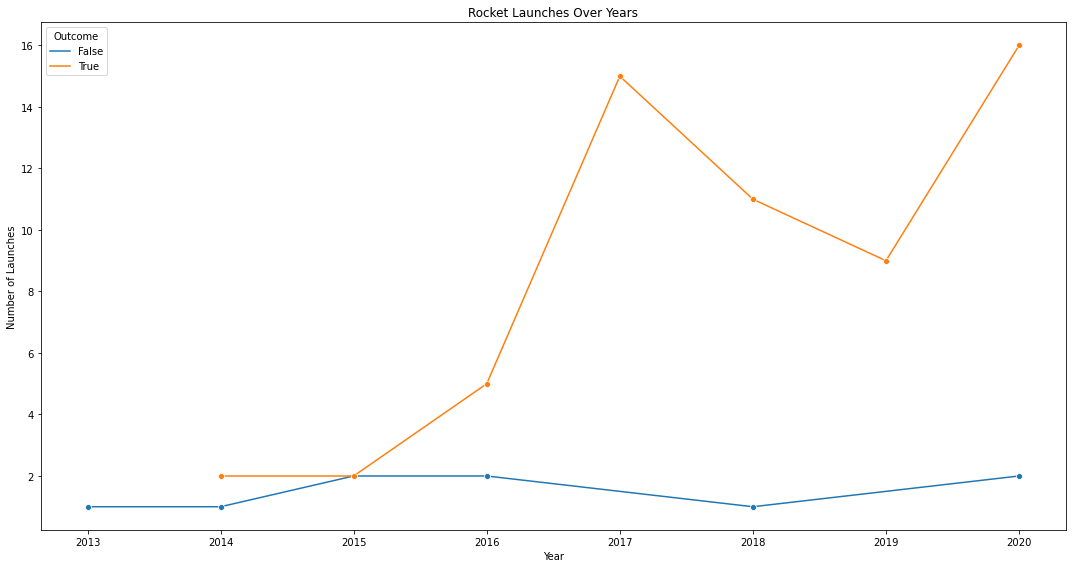

In [117]:

# 假设你的数据存在一个名为 df 的 DataFrame 中
# 且该数据有 'Date' 和 'Outcome' (True 表示成功, False 表示失败) 这两个列

# 将 Date 列转换为年份
df['Year'] = pd.to_datetime(df['Date']).dt.year

# 使用 groupby 对数据按年份和结果进行分组，并统计数量
grouped_data = df.groupby(['Year', 'Outcome']).size().reset_index(name='Count')

# 绘制折线图
plt.figure(figsize=(15, 8))
sns.lineplot(x='Year', y='Count', hue='Outcome', data=grouped_data, marker='o')

plt.title("RFirstBs Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Launches")
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()

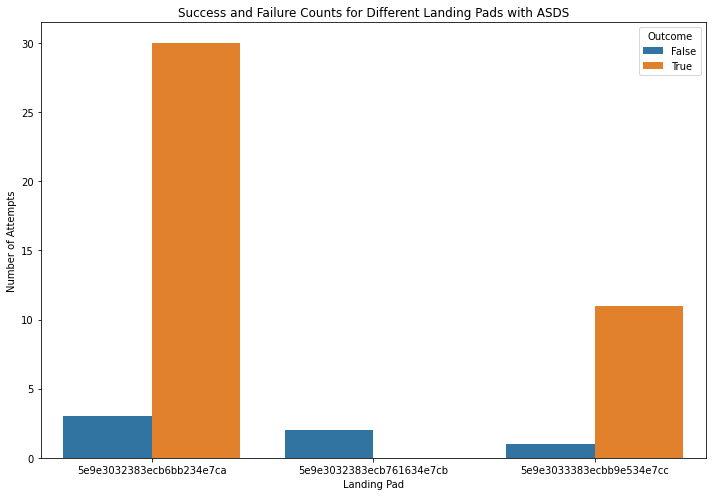

In [120]:
# 首先，筛选出 Landing 为 ASDS 的数据
asds_data = df[df['Landing'] == 'ASDS']

# 使用 groupby 对数据按 LandingPad 和 Outcome 进行分组，并统计数量
grouped_data = asds_data.groupby(['LandingPad', 'Outcome']).size().reset_index(name='Count')

# 绘制条形图展示每个 LandingPad 的成功与失败次数
plt.figure(figsize=(10, 7))
sns.barplot(x='LandingPad', y='Count', hue='Outcome', data=grouped_data)

plt.title("Success and Failure Counts for Different Landing Pads with ASDS")
plt.xlabel("Landing Pad")
plt.ylabel("Number of Attempts")
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()

In [130]:
contingency_table = pd.crosstab(df['Outcome'], df['Legs'])

# 使用Fisher的精确检验
odds_ratio, p_value = fisher_exact(contingency_table)

print("Odds Ratio:", odds_ratio)
print("P-value:", p_value)

Odds Ratio: 16.857142857142858
P-value: 0.04282933160285528


In [131]:
contingency_table = pd.crosstab(df['Outcome'], df['GridFins'])

# 使用Fisher的精确检验
odds_ratio, p_value = fisher_exact(contingency_table)

print("Odds Ratio:", odds_ratio)
print("P-value:", p_value)

Odds Ratio: 8.285714285714286
P-value: 0.07968296161600735


In [132]:
contingency_table = pd.crosstab(df['Outcome'], df['Reused'])

# 使用Fisher的精确检验
odds_ratio, p_value = fisher_exact(contingency_table)

print("Odds Ratio:", odds_ratio)
print("P-value:", p_value)

Odds Ratio: 3.274193548387097
P-value: 0.17144178682713626
